# Analisi dei gruppi (clustering): Introduzione

Con la PCA, ci siamo posti l'obiettivo di trovare una rappresentazione parsimoniosa dei dati iniziali che spieghi gran parte della varianza totale. Come la PCA, l'analisi dei gruppi o **clustering** è un insieme di tecniche di apprendimento non supervisionato (**unsupervised learning**), che ha l'obiettivo di semplificare i dati. 
A differenza della PCA, il clustering ha lo scopo di trovare sottogruppi (*cluster*) distinti in un insieme di dati, tali che:

* osservazioni nello **stesso cluster** siano quanto più *simili* tra loro (Proprietà P1)
* osservazioni di **cluster diversi** siano quanto più *differenti* tra loro (Proprietà P2).

In termini più formali, l'analisi dei gruppi mira a raggruppare le $n$ osservazioni in $K$ cluster,  dove $K$ può essere **specificato** a priori o scelto in base ad ulteriori criteri di ottimizzazione. 
Nello specifico, il vero oggetto del clustering sono gli indici di riga, denotati con $i=1,\ldots,n$, che vogliamo suddividere nei $K$ cluster, $C_1, C_2, \dots, C_K$.

Esistono diverse tecniche di clustering. In questo corso vedremo le due principali:

* Clustering $K$-means
    
* Clustering gerarchico

Prima di introdurle è però necessario che 
* carichi un data set di esempio e  
* ti illustri i concetti di *distanza/dissimiliarità* tra osservazioni e tra gruppi (cluster), cruciali, come vedremo, di volta in volta, per stabilire implicitamente il criterio di raggruppamento.

## Data set di esempio (simulato)

Carica le librerie necessarie

In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Il data set che utilizzerò per illustrarti gli algoritmi di clustering, per motivi didattici, è un data set artificiale, ottenuto simulando 50 righe/osservazioni e 2 colonne/variabili incorrelate. Le prime 25 righe provengono da un cluster con media pari a $(\mu_1,\mu_2)=(3,-4)$, le restanti hanno media pari a $(0,0)$. In una terza colonna `true_cluster` di tipo `factor`, registriamo un'etichetta pari a 1 per le prime 25 righe e pari a 2 per le ultime 25 righe. In tal modo abbiamo generato un data set avente esattamente $K=2$ cluster.  
Non è essenziale che tu sappia come simulare un data set, quindi se vuoi, puoi semplicemente eseguire il codice nel blocco seguente e saltare i dettagli riportati come commento. Avrai la possibilità di applicare le tecniche di clustering a data set reali nelle prossime sessioni di open Lab.

In [2]:
#simulazione data set artificiale 

#inizializzazione della generazione. Se usi un k (detto "seme") diverso genererai un data set differete. 
#Puoi scegliere un numero intero qualsiasi.
k=123
set.seed(k)

nsim <- 50 
df <- data.frame(x1 = rnorm(nsim),
                 x2 = rnorm(nsim)) #generiamo 50 variabili da una v.a. normale standard 

mu1=3
mu2=-4
df$x1[1:25] <- df$x1[1:25] + mu1
df$x2[1:25] <- df$x2[1:25] + mu2 #modifichiamo la media delle prime 25 osservazioni

#aggiungiamo una terza colonna in cui registriamo il vero cluster di appartenenza da usare in seguito
df$true_cluster <- factor(c(rep(1, 25), rep(2, 25))) 

Puoi diagrammare il data set e colorare le osservazioni in base al cluster di appartenenza

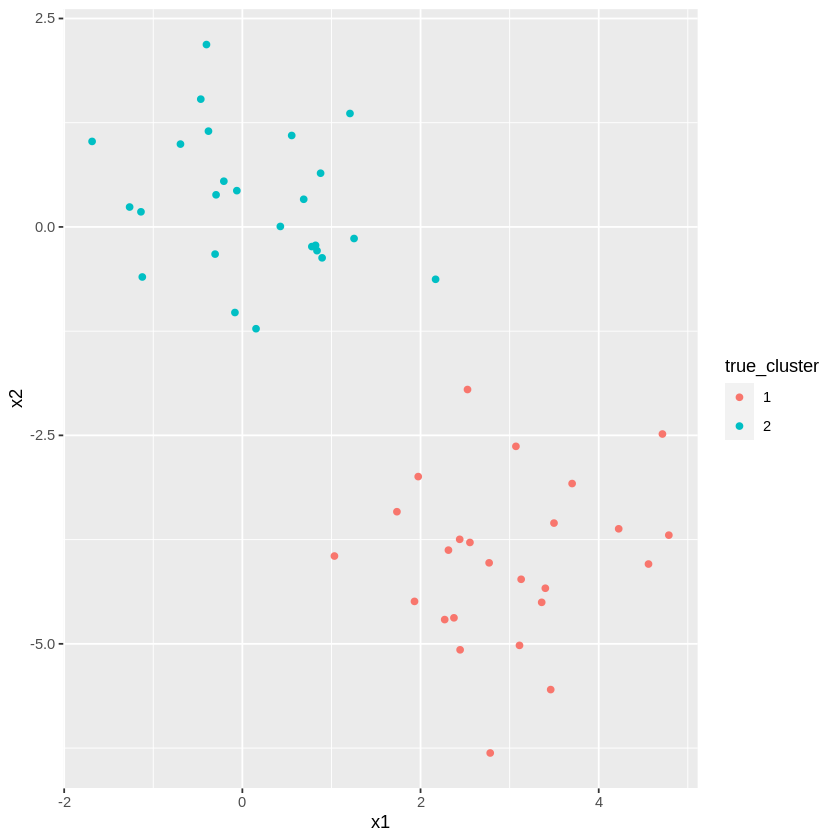

In [3]:
true_cluster_plot <- ggplot(data = df) +
                      geom_point(mapping = aes(x1, x2, colour = true_cluster))
true_cluster_plot

##  Distanza/dissimiliarità tra osservazioni

### Distanza euclidea
La scelta più comune per la distanza tra due osservazioni/righe $\bf{x}_i$ e $\bf{x}_{q}$, denotata con  $d_{E}(\bf{x}_{i},\bf{x}_{q})$, è la distanza *euclidea*, definita come $$d_E(\bf{x}_{i},\bf{x}_{q})=\sqrt{(x_{i,1}-x_{q,1})^2+\ldots+(x_{i,p}-x_{q,p})^2}=\sqrt{\sum_{j = 1}^{p} (x_{i,j}-x_{q,j})^{2}}.$$
    
In altre parole, è la radice quadrata della somma dei quadrati delle differenze tra i valori assunti dalle variabili  omologhe.

Per calcolare la distanza euclidea tra tutte le coppie di osservazioni di un data set basta applicare la funzione `dist()` (matrice delle distanze) del pacchetto `stats` che genera un oggetto di classe `"dist"` 

In [4]:
euclid.d.matrix <- dist(select(df, x1:x2)) #che è equivalente a
#euclid.d.matrix <- dist(df[,1:2])
class(euclid.d.matrix)

[1] "dist"

### Distanza basata sulla **correlazione** (correlation-based) tra le osservazioni/righe
Due osservazioni/righe sono considerate simili, e quindi raggruppate nello stesso cluster, se correlate positivamente tra loro. Viceversa, due osservazioni/righe sono considerate dissimili, e quindi  raggruppate in gruppi diversi, se correlate negativamente. 
Pertanto, la distanza basata sulla correlazione deve risultare tanto maggiore quanto più è basso l'indice di correlazione tra due righe, e viceversa. Per poter riflettere questa inversa proporzionalità da un punto di vista quantitativo, e calcolare correttamente la matrice delle distanze basate sulla correlazione, ti ricordo che 

* la funzione `cor()` calcola  la matrice di correlazione (di dimensioni $p \times p$) tra le variabili/colonne di un data set, per esempio `df[,1:2]` attraverso l'istruzione `cor(df[,1:2])` (di dimensioni $2 \times 2$). Tuttavia per calcolare la matrice delle distanze basata sulla correlazione abbiamo bisogno della matrice di correlazione tra le osservazioni/righe, ed è quindi necessario applicare la funzione `cor()` al data set trasposto. Per poter trasporre il data set attraverso la funzione `t()`, bisogna prima convertirlo in matrice, attraverso la funzione `as.matrix()`.

* per convertire tale oggetto di classe `"matrix"` in un oggetto di classe `"dist"`, basta usare la funzione `as.dist()`

* il valore di ogni elemento della matrice di correlazione è compreso fra -1 e 1. Per rispettare l'associazione tra indice di correlazione e similarità tra le osservazioni, nonché per rendere la distanza positiva, si considera la matrice di correlazione ottenuta come `1-cor(df[,1:2] %>% as.matrix() %>% t())`, i cui elementi risulteranno compresi tra 0 e 2 e tanto maggiori quanto più è basso l'indice di correlazione.

In [5]:
corr.d.matrix <- as.dist(1-cor(df[,1:2] %>% as.matrix() %>% t()))
#che equivale a 
corr.d.matrix <- as.dist(1-cor(as.matrix(t(df[,1:2]))))
class(corr.d.matrix)

[1] "dist"

In ogni caso, non è necessario ricordare la genesi dell'istruzione `as.dist(1-cor(x %>% as.matrix() %>% t()))`, ma potresti trovare pratico incorporarla in una funzione, da richiamare in seguito

In [6]:
corr.d.matrix.fun <- function(x) as.dist(1-cor(x %>% as.matrix() %>% t()))
corr.d.matrix <- corr.d.matrix.fun(df[,1:2])

Tuttavia, per dataset con sole $p=2$ colonne la correlazione è banale e gli elementi della matrice saranno tutti pari a 1 in modulo, cambierà solo il segno.
Tratterai un caso meno banale per esempio nell'open Lab di questa unità sul data set reale `COVID-19`.
La distanza basata sulla correlazione tra righe tende a catturare la tendenza al variare insieme delle singole osservazioni, a prescindere dalla vicinanza dei punti sperimentali (catturata invece dalla distanza euclidea).

* *Esempio*: un venditore online vuole raggruppare i propri clienti sulla base dei loro precedenti acquisti. Supponiamo che il dataset sia formato dal numero di oggetti acquistati per ogni prodotto (variabile/colonna) da ogni cliente (riga/osservazione). Il venditore potrebbe essere interessato a vedere delle similiarità tra i clienti che hanno acquistato carrelli di prodotti simili, a prescindere dal numero di oggetti acquistati. In tal caso dovrà scegliere la distanza basata sulla correlazione tra osservazioni. Scegliendo la distanza euclidea, infatti, clienti che comprano poche cose, vengono clusterizzati insieme indipendentemente da ciò che hanno acquistato.

### Altre distanze 

#### Distanza di Manhattan

La distanza di Manhattan tra due osservazioni/righe $\bf{x}_i$ e $\bf{x}_q$ è la somma dei valori assoluti delle differenze tra le variabili omologhe.
$$d_{M}(\bf{x}_i,\bf{x}_q) = \sum_{q = 1}^{p} \left| x_{i,j}-x_{q,j} \right|.$$

Per calcolare la distanza di Manhattan tra tutte le coppie di osservazioni di un data set basta applicare la funzione `dist()` (matrice delle distanze) del pacchetto `stats` con l'argomento aggiuntivo `method="manhattan"`.


In [7]:
manhattan.d.matrix <- dist(select(df, x1:x2), method="manhattan") #che è equivalente a
#manhattan.d.matrix <- dist(df[,1:2], method="manhattan")
class(manhattan.d.matrix)

[1] "dist"

#### Distanza di Canberra

La distanza di Canberra è una versione pesata della distanza di Manhattan, dove il valore assoluto delle differenze tra variabili omologhe viene diviso per la somma dei valori assoluti delle variabili omologhe.
$$d_C(\bf{x}_i,\bf{x}_q) = \sum_{q = 1}^{n} \frac{\left| x_{i,j}-x_{q,j} \right|}{\left| x_{i,j} \right| + \left| x_{q,j} \right|}.$$

Per calcolare la distanza di Canberra tra tutte le coppie di osservazioni di un data set, basta applicare la funzione `dist()` (matrice delle distanze) del pacchetto `stats` con l'argomento aggiuntivo `method="canberra"`.

In [8]:
canberra.d.matrix <- dist(select(df, x1:x2), method="canberra") #che è equivalente a
#canberra.d.matrix <- dist(df[,1:2], method="canberra")
class(canberra.d.matrix)

[1] "dist"

## Linkage
Per alcuni algoritmi (come quello gerarchico) c'è bisogno di estendere il concetto di dissimilarità tra osservazioni a quello di dissimilarità tra due cluster, noto come *linkage*.
Per farlo, dobbiamo considerare, sulla base della distanza (tra osservazioni) scelta, 
* tutte le possibili distanze tra coppie di osservazioni l'una in un primo cluster, l'altra in un secondo cluster di interesse 
* e scegliere la massima, la media o la minima distanza. 
Tali quantità sono chiamate, per definizione,  *complete*, *average* e *single* linkage, rispettivamente, tra i due cluster.

In aggiunta a queste tre, si può definire anche il *centroid linkage* come la distanza tra i centroidi dei due cluster considerati. 
Tuttavia, complete e average linkage sono senza dubbio quelle più diffuse e quelle che utilizzeremo prevalentemente nei lab di questo corso.
Quando $k=n$, ossia quando ogni cluster include una ed una sola osservazione, qualsiasi linkage coincide con la distanza $d(\bf{x}_i,\bf{x}_j)$ già definita per calcolare la dissimilarità tra le osservazioni $\bf{x}_i$ ed $\bf{x}_j$ con $i \neq j$.

Complimenti! Sei pronto per utilizzare nella prossima unità i concetti appena appresi, applicandoli al clustering k-means!